In [ ]:
#@title Cython and pycocotools installation
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
#@title Mountowanie dysku
import ntpath
#importowanie dysku
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title Defining dataset
import os
import numpy as np
import torch
import glob
import json
import ntpath
import torch.utils.data
from PIL import Image


class volleyBallsDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs =list(glob.glob(root+"/*.jpg"))
        self.masks =list(glob.glob(root+"/*.png"))

    def __getitem__(self, idx):
        # load images
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        # print(img_path)
        img = Image.open(img_path).convert("RGB")
        mask=Image.open(mask_path)


        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # import bboxes from json file
        boxes = []
        with open('/content/gdrive/MyDrive/CPO2D/FinalDataset2/metadata.json') as json_file:
          data = json.load(json_file)
          filename = ntpath.basename(img_path)
          boxes.append(data[filename])

        # convert bboxes to pytorch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # # there is only one class
        num_objs = len(obj_ids)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks=torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
#@title Test if dataset was loaded correctly
from PIL import ImageDraw
imgs =list(glob.glob("/content/gdrive/MyDrive/CPO2D/FinalDataset2/*.jpg"))
print("number of loaded images: " + str(len(imgs)))
test=volleyBallsDataset("/content/gdrive/MyDrive/CPO2D/FinalDataset2")
print(test[1])

number of loaded images: 1000
(<PIL.Image.Image image mode=RGB size=480x270 at 0x7FB33DC40EE0>, {'boxes': tensor([[136., 207., 156., 227.]]), 'labels': tensor([1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([1]), 'area': tensor([400.]), 'iscrowd': tensor([0])})


In [ ]:
#@title Pretrained model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#@title pobieranie repo
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
#@title Uninstalling current torch version
!pip uninstall torchvision
!pip uninstall torch

Found existing installation: torchvision 0.15.2+cu118
Uninstalling torchvision-0.15.2+cu118:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.15.2+cu118.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.60cfec8e.so.11.0
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libnvjpeg.70530407.so.11
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libz.e3d3156c.so.1
    /usr/local/lib/python3.10/dist-packages/torchvision/*
Proceed (Y/n)? y
  Successfully uninstalled torchvision-0.15.2+cu118
Found existing installation: torch 2.0.1+cu118
Uninstalling torch-2.0.1+cu118:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch

In [ ]:
#@title Installing legacy torch version
!pip install torch==1.13.1 torchvision==0.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 66.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torc

In [ ]:
#@title Importing torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
#@title Defining transform function for training set
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
#@title Connecting GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#@title Training
import utils
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = volleyBallsDataset('/content/gdrive/MyDrive/CPO2D/FinalDataset2', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
# images = list(torch.FloatTensor([image, 1080, 1920]) for image in images)
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
print(predictions)

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


In [ ]:
#@title Split dataset into training and verification sets
# use our dataset and defined transformations
dataset = volleyBallsDataset("/content/gdrive/MyDrive/CPO2D/FinalDataset2", get_transform(train=True))
dataset_test = volleyBallsDataset("/content/gdrive/MyDrive/CPO2D/FinalDataset2", get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [ ]:

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# let's train it for 5 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 40 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,print_freq=40)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/113]  eta: 0:22:15  lr: 0.000050  loss: 4.4503 (4.4503)  loss_classifier: 0.8621 (0.8621)  loss_box_reg: 0.1164 (0.1164)  loss_mask: 3.4350 (3.4350)  loss_objectness: 0.0361 (0.0361)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 11.8175  data: 2.8878  max mem: 10945
Epoch: [0]  [ 40/113]  eta: 0:03:00  lr: 0.001834  loss: 0.2730 (0.8296)  loss_classifier: 0.0920 (0.2309)  loss_box_reg: 0.1231 (0.1052)  loss_mask: 0.0201 (0.4585)  loss_objectness: 0.0202 (0.0325)  loss_rpn_box_reg: 0.0025 (0.0026)  time: 2.2843  data: 0.0298  max mem: 10945
Epoch: [0]  [ 80/113]  eta: 0:01:20  lr: 0.003617  loss: 0.2157 (0.5588)  loss_classifier: 0.0495 (0.1461)  loss_box_reg: 0.1492 (0.1239)  loss_mask: 0.0077 (0.2656)  loss_objectness: 0.0039 (0.0206)  loss_rpn_box_reg: 0.0015 (0.0026)  time: 2.3951  data: 0.0309  max mem: 10945
Epoch: [0]  [112/113]  eta: 0:00:02  lr: 0.005000  loss: 0.0969 (0.4523)  loss_classifier: 0.0223 (0.1125)  loss_box_reg: 0.0633 (0.1145)  loss_mask: 0.0106 (0.20

In [ ]:
#@title predykcje
import torchvision.transforms as transforms
from PIL import Image
# pick one image from the test set
img = Image.open("/content/gdrive/MyDrive/CPO2D/frames/frame_138.jpg")
# Definiuj transformacje
transform = transforms.Compose([
    transforms.ToTensor()
])

# Zastosuj transformacje do obrazu
img_tensor = transform(img)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img_tensor.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[1604.8870,  529.6833, 1656.5520,  581.9866]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9966], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

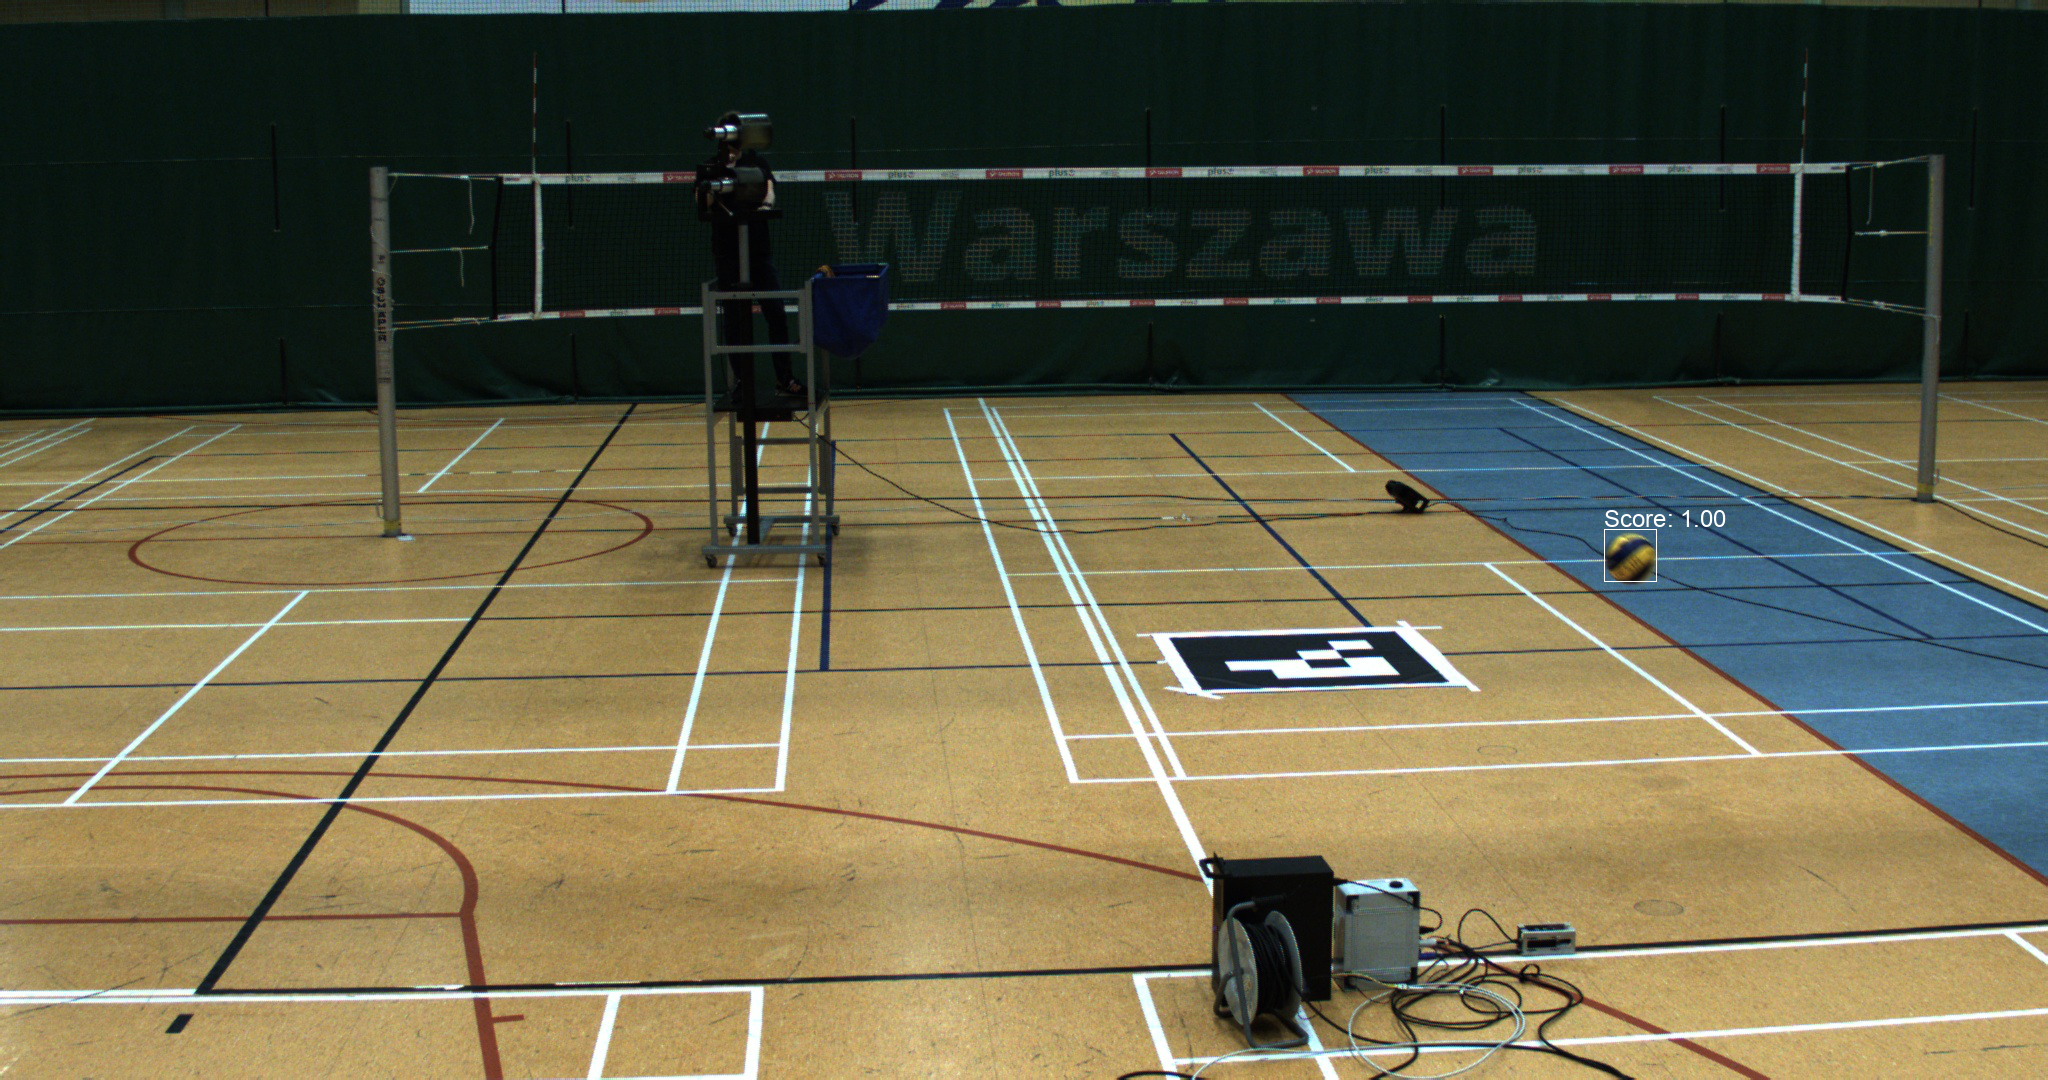

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# Konwertuj tensor na obiekt PIL.Image
img1 = Image.fromarray(img_tensor.mul(255).permute(1, 2, 0).byte().numpy())

# Pobierz wartość score z predykcji
score = prediction[0]['scores'].cpu().numpy()[0]

# Pobierz bbox
boxes = prediction[0]['boxes'].cpu().numpy()
bbox = boxes[0]

# Przygotuj kształt bbox
shape = [(int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3]))]

# Rysuj bbox i dodaj napis z score
draw = ImageDraw.Draw(img1)
draw.rectangle(shape, outline="white")
font = ImageFont.truetype("/content/gdrive/MyDrive/CPO2D/arial.ttf", size=24)
draw.text((shape[0][0], shape[0][1] - 24), f"Score: {score:.2f}", fill="white",font=font)

# Wyświetl obraz z bbox i napisem
img1.show()
img1.save('/content/gdrive/MyDrive/CPO2D/zdj4.jpg')